# Example: PyRayHF Spherical Gradient Raytracing

### Background: Ray Equations in Spherical Geometry

In spherical geometry, rays are described in $(r, φ)$ coordinates:

- **$r$** = Earth radius + altitude [km]
- **$φ$** = surface arc angle [rad]
- **$v = (v_r, v_φ)$** = unit tangent vector
- **$s$** = arc length [km]
- **$n(r, φ)$** = $μ$ (phase index)

The ray equations become:
$$
dr/ds = v_r
$$
$$
dφ/ds = v_φ / r
$$
$$
dv_r/ds = (∂n/∂r - (∇n·v) v_r)/n + (v_φ^2)/r
$$
$$
dv_φ/ds = ((∂n/∂φ)/r - (∇n·v) v_φ)/n - (v_r v_φ)/r
$$


Here the geometry includes Earth curvature explicitly, making this method essential for long-range HF raytracing.

---

### Specifics in PyRayHF

- Geometry (bending) uses the **phase index $μ$**
- Group delay integrates the **group index $μ'$** (mup)f provided via `mup_func`
- Refractive index gradients $(∂μ/∂r, ∂μ/∂φ)$ are provided by `build_refractive_index_interpolator_rphi`
- Termination conditions stop the ray when it:
  - Hits the ground $(r = R_E + z_{ground})$
  - Leaves the radial or azimuthal bounds
  - Exceeds maximum arc length

This method is the most realistic in PyRayHF since it accounts for **curved-Earth geometry** while allowing for horizontally varying ionospheres.


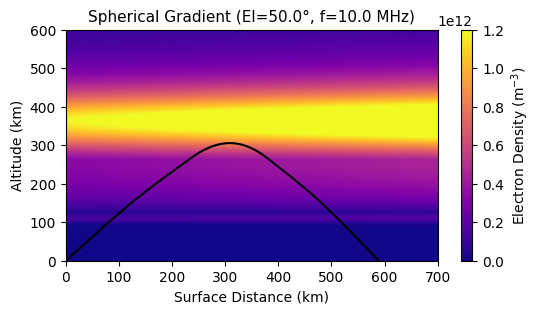

--------------------------------------------------
Gradient-based spherical raytracing:
--------------------------------------------------
Group Path (km):  863.9433228011467
Group delay (sec):  0.0033308603837504686
Ground_ Range (km):  589.5295689652877
x midpoint (km):  299.3606078980972
z midpoint (km):  304.79357526370404
--------------------------------------------------
Elapsed time (sec):  0.6153016840107739
--------------------------------------------------


In [1]:
#!/usr/bin/env python
import numpy as np
import pickle
import matplotlib.pyplot as plt
from PyRayHF.library import find_X, find_Y, find_mu_mup
from PyRayHF.library import build_refractive_index_interpolator_rphi
from PyRayHF.library import trace_ray_spherical_gradient
from PyRayHF.library import constants
from scipy.interpolate import RegularGridInterpolator
import time

# Load an ionospheric profile
# See Example_Generate_Input_Arrays for how to create this input file using
# PyIRI.
file_open = 'Example_input.p'
input_arrays = pickle.load(open(file_open, 'rb'))
alt_km = input_arrays["alt"]
Ne = input_arrays["den"]
Babs = input_arrays["bmag"]
bpsi = input_arrays["bpsi"]

# Ensure ground level is included
h_ground = 0
if alt_km[0] > h_ground:
    Ne0 = np.interp(h_ground, alt_km, Ne)
    Babs0 = np.interp(h_ground, alt_km, Babs)
    bpsi0 = np.interp(h_ground, alt_km, bpsi)
    alt_km = np.insert(alt_km, 0, h_ground)
    Ne = np.insert(Ne, 0, Ne0)
    Babs = np.insert(Babs, 0, Babs0)
    bpsi = np.insert(bpsi, 0, bpsi0)

# Define inputs
elevation_deg = 50.
f0_Hz = 10e6
mode = "O"

# Create 2D density grid (Ne assumed horizontally uniform)
nx = 500
xmax = 1000
x_grid = np.linspace(0, xmax, nx)
z_grid = alt_km
Xg, Zg = np.meshgrid(x_grid, z_grid)
Ne_grid = np.tile(Ne[:, np.newaxis], (1, nx))
Babs_grid = np.tile(Babs[:, np.newaxis], (1, nx))
bpsi_grid = np.tile(bpsi[:, np.newaxis], (1, nx))

# Add some gradient to it
Ne_gradient = Ne_grid * (1.0 + 0.5 * (Xg / Xg.max()))

# Start the timer to time the code
start_time = time.perf_counter()

# Calculate plasma parameters
X = find_X(Ne_gradient, f0_Hz)
Y = find_Y(f0_Hz, Babs_grid)

mu, mup = find_mu_mup(X, Y, bpsi_grid, mode)
mup = np.where((mup < 1e-3) | np.isnan(mup), np.nan, mup)
mup0 = mup[0]

# Build interpolator from spherical μ grid
_, _, R_E, _ = constants()
r_grid = R_E + z_grid   # km
phi_grid = x_grid / R_E # rad
n_and_grad_rphi = build_refractive_index_interpolator_rphi(r_grid, phi_grid, mu)

# Build μ' interpolator for group delay
mup_interp_rphi = RegularGridInterpolator((r_grid, phi_grid), mup,
                                     bounds_error=False,
                                     fill_value=np.nan)
mup_func_rphi = lambda x, z: mup_interp_rphi(np.column_stack([R_E + z, x / R_E]))

# Raytrace
result = trace_ray_spherical_gradient(n_and_grad_rphi=n_and_grad_rphi,
                                      x0_km=0.0,
                                      z0_km=0.0,
                                      elevation_deg=elevation_deg,
                                      s_max_km=4000.,
                                      R_E=R_E,
                                      mup_func=mup_func_rphi)

# Stop the timer
end_time = time.perf_counter()
# Calculate and print the elapsed time
elapsed_time = end_time - start_time

# Plot results
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6, 3)
ax_plot = ax
ax_plot.set_xlim(0, 700)
ax_plot.set_ylim(0, 600)
ax_plot.set_facecolor("lightgray")
ax_plot.set_ylabel('Altitude (km)')
ax_plot.set_xlabel('Surface Distance (km)')
vmin = 0
vmax = 1.2e12
color_ticks = np.arange(vmin, vmax + 2e11, 2e11)
pc = ax_plot.pcolormesh(Xg, Zg, Ne_gradient, shading='auto',
                        cmap='plasma', vmin=vmin, vmax=vmax)
ax_plot.plot(result['x'], result['z'], c='black')
ax_plot.set_title(f"Spherical Gradient (El={elevation_deg:.1f}°, f={f0_Hz/1e6} MHz)", fontsize=11)
plt.colorbar(pc, label='Electron Density (m$^{-3}$)', ax=ax_plot,
             ticks=color_ticks)
plt.savefig('/Users/vmakarevich/Documents/GitHub/PyRayHF/docs/examples/figures/Spherical_Gradient.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

 
# Print diagnostics
print('--------------------------------------------------')
print('Gradient-based spherical raytracing:')
print('--------------------------------------------------')
print('Group Path (km): ', result['group_path_km'])
print('Group delay (sec): ', result['group_delay_sec'])
print('Ground_ Range (km): ', result['ground_range_km'])
print('x midpoint (km): ', result['x_midpoint'])
print('z midpoint (km): ', result['z_midpoint'])

print('--------------------------------------------------')
print('Elapsed time (sec): ', elapsed_time)
print('--------------------------------------------------')